In [16]:
from IPython.display import Image
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.linear_model import LinearRegression

# Get demonstration data: 

In [17]:
EXPLORATION_YEAR = 2011 

def get_daily_weather_data_dump():
    return pd.read_csv("central_park_1800_2020.csv",parse_dates=['DATE'])

def gen_weather_data_for_demo():
    data = get_daily_weather_data_dump()
    cols_names = {'DATE':'date','SNOW':'snow_mm','PRCP':'rainfall_mm','TMAX':'max_temperature','NAME':'station_name'} 
    data = data.dropna(subset = ['TMAX']).rename(columns = cols_names).sort_values(by='date')
    data['year'] = data.date.dt.year
    data['month'] = data.date.dt.month
    data['week'] = data.date.dt.isocalendar().week
    data['day'] = data.date.dt.day
    data['dayofyear'] = data.date.dt.dayofyear
    data['jul_date'] = data.date.map(lambda d: pd.Timestamp.to_julian_date(d)) # a floating point represntation of dates
    data['rainfall_mm_10'] = data.rainfall_mm * 10 # changed scale to seperate it better visually in the following graphs 
    return data

data = gen_weather_data_for_demo()

# Time series data introduction:
## Data attributes, Attributes validation, and common data preparation steps:
From weather forecasting to stock market forecasting or medical diagnosis, solving many of the world’s greatest challenges relies on the ability to model time series data. 

Time series can be defined as a collection of random variables indexed by the order they are obtained in time.
The modeling goal is to acquire an understanding of the underlying structure that produced the observed data while considering its unique time dependencies and characteristics.

## So.. How do we start? 
The most important step is to **define** the research data attributes by the **common literature terms**. 

Identifying the data characteristics is important for **model selection** since some models have shown greater success modeling certain data types. In addition, some models make **assumptions** about the data that require **data preparation**.


In the following sections, I will demonstrate these concepts using weather data measured at the Central Park of New York between the years 1800-2020.

Let's begin!

# Time series data attributes terminology:

## Is the data **univariate/ multivariate**? 
Univariate time series consists of a single sequence of observations recorded over time increments.

A multivariate time series data has more than one time-dependent series.

<AxesSubplot:title={'center':'Multivariate Time Series Example: weather features in 2011'}, xlabel='date'>

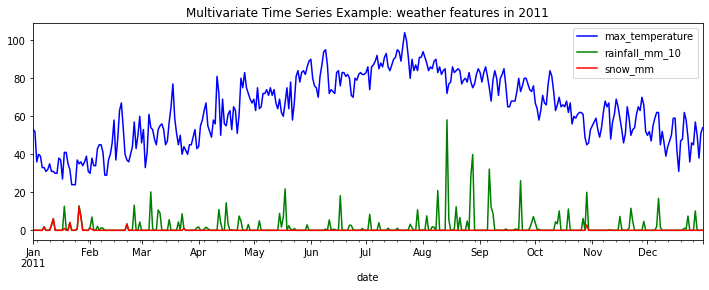

In [18]:
data[data.year == EXPLORATION_YEAR].plot(x='date',y=['max_temperature','rainfall_mm_10','snow_mm'], color = [
    'blue','green','red'], figsize=(12,4), title=f'Multivariate Time Series Example: weather features in {EXPLORATION_YEAR}')

## What is the sampling frequency of the time entries? 
Is the time series containing a value per year? month? second?   

For example, temperature is a continuous signal and therefore temperature measurements can be sampled once an hour, minute, second and more. 

If the data is multivariate, it can also have a **multi-frequency** structure, meaning each time series can be sampled at a different time frequency. 

Multi-frequency data requires special attention in feature engineering, to be explained below. 


<AxesSubplot:title={'center':'Multi Frequency Time Series Example of weather features in 2011'}, xlabel='date'>

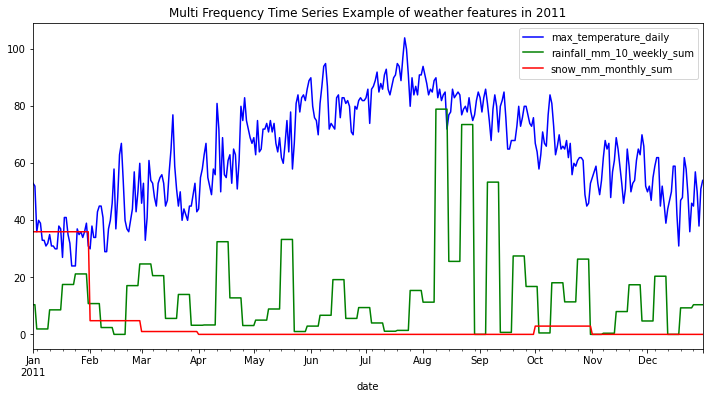

In [19]:
def gen_multi_freq_data(data):
    monthly_data = data.groupby(['year','month']).agg({'snow_mm':'sum'}).reset_index().dropna(axis=1).rename(
        columns = {'snow_mm':'snow_mm_monthly_sum'})
    weekly_data = data.groupby(['year','week']).agg({'rainfall_mm_10':'sum'}).reset_index().dropna(axis=1).rename(
        columns = {'rainfall_mm_10':'rainfall_mm_10_weekly_sum'})
    data_multi_freq = data[['date','jul_date','week','year','month','day','max_temperature']].rename(
        columns = {'max_temperature':'max_temperature_daily'}).merge(monthly_data, on=['year','month'], how='left')
    data_multi_freq = data_multi_freq.merge(
        weekly_data, on=['year','week'], how='left')
    return data_multi_freq

data_multi_freq = gen_multi_freq_data(data)
data_multi_freq[data_multi_freq.year == EXPLORATION_YEAR].plot(
    x='date',y=['max_temperature_daily','rainfall_mm_10_weekly_sum','snow_mm_monthly_sum'],figsize=(
        12,6),color = ['blue','green','red'], title = f'Multi Frequency Time Series Example of weather features in {EXPLORATION_YEAR}')

## Is the data **Stationary**?
In a stationary time series, the series summary statistics  such as the mean don’t change significantly over time. 

When performing statistical time series modeling we will usually want to approximate the series summary statistics such as expected value, variance and correlation between the history values to the next values. 

By working with stationary series we can utilize that summary statistics don’t change over time and assume they will not change at the prediction series values. Therefore, there are less model parameters to approximate making stationary data easier to analyze and predict.
   
To [check **stationarity**](https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322), we can calculate statistics such as the mean and variance of the series values at different time intervals,and make sure there are no significant differences between the results over time. 

We can use a **statistical test** to check whether the data is stationary or not, such as the **ADF test** (Augmented Dickey-Fuller test).  
    
The test is applied to the model:

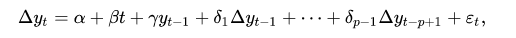

In [20]:
Image(filename="ADF_formula.png")

**ADF test parameters**: 
α is a constant, β is the coefficient on a time trend. In our case, we are interested in detecting the dependency of each time entry in its previous value, so the we set the regression for α=0, β=0. we set maxlag to 365 from computational reasons. we set the lag search function for 't-stat', which starts with the choice of maxlag and drops a lag until the t-statistic on the last lag length is significant using a 5%-sized test.

#### **the test results**:
here, the p-value if above 0.05, means we can't reject the null hipothesis that the data has a unit root, means its **not stationary**. 


In [21]:
p_value_res = adfuller(data[data.year == EXPLORATION_YEAR].max_temperature.values, maxlag = 5, autolag = 't-stat',regression = 'nc')[1]
print(f'Test Data: Max Temperature series of {EXPLORATION_YEAR}, Result P_value : {round(p_value_res,2)}')

Test Data: Max Temperature series of 2011, Result P_value : 0.6


## Does the data have a **seasonality** pattern?  
seasonality is the presence of alterations that occur at specific regular time intervals, such as weekly, monthly or more. 

<AxesSubplot:title={'center':' Yearly seasonality example: max temperature per day between 2010-2020'}, xlabel='date', ylabel='max_temperature'>

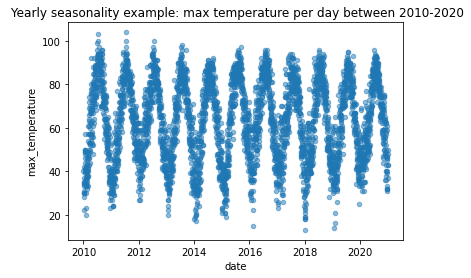

In [22]:
START_YEAR, END_YEAR = 2010, 2020
data[data.year.between(START_YEAR, END_YEAR)].plot.scatter(
    'date', 'max_temperature',alpha = 0.5, title = f' Yearly seasonality example: max temperature per day between {START_YEAR}-{END_YEAR}')

**How to detect the [seasonality patterns](https://www.sciencedirect.com/science/article/pii/089571779390126J) of the series?**

we can check the [autocorrelation](https://medium.com/@dganais/autocorrelation-in-time-series-c870e87e8a65), the linear correlation of a series with a lagged version of itself as a function of the time lag between them. 

The **ACF** (autocorrelation function value)can be calculated for a range of lags, lags with extreme autocorrelation values define the seasonality pattern. Non linear autocorrelation can be checked by other serial dependency tests such as the Durbin-Watson test. 

In the following **ACF plot**, we can see that the highest correlation is achieved by a lag of 1, which means that the observation at time t is mostly explained by the observation at time t-1. We can also see an yearly high correlation, demonstrating the yearly weather seasonality, and a half year pattern of negative correlation, demonstrating the seasons changing.


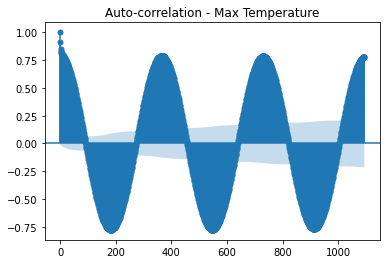

In [23]:
NUM_YEARS,DAYS_PER_YEAR = 3, 365
data.sort_values(by='date', inplace=True)
plot_acf(data.max_temperature, lags = np.arange(DAYS_PER_YEAR * NUM_YEARS), title = 'Auto-correlation - Max Temperature');

### Are there **missing values**?
After we understand the data sampling frequency, some time entries may be missing. 

For example, a series of hourly temperature measurements may not include some records temperature due to a temporary malfunction of the recording system.  

<AxesSubplot:title={'center':'Missing Time Series Values: Max temperature in 2011'}, xlabel='date'>

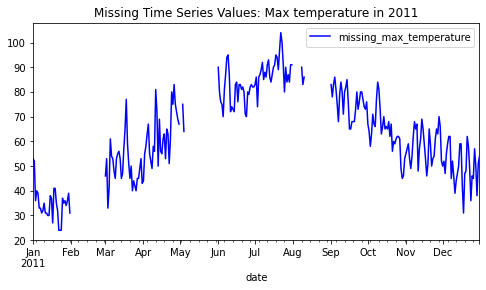

In [24]:
def add_missing_max_temperature_col(data):
    data['missing_max_temperature'] = data.max_temperature.copy()
    indices = ((data.year == EXPLORATION_YEAR)&(data.month.isin([2,5,8])))
    data.loc[indices, 'missing_max_temperature'] = [np.random.choice(
        [np.nan, val], p=[0.8,0.2]) for val in data.loc[indices].max_temperature]
    return data

data = add_missing_max_temperature_col(data)
data[data.year == EXPLORATION_YEAR].plot(x='date',y=['missing_max_temperature'],figsize=(8,4),color = [
    'blue','green','red'], title = f'Missing Time Series Values: Max temperature in {EXPLORATION_YEAR}')

### Does the time series have Auxiliary features?
Auxiliary features are any attributes that provide additional information of the whole time series.

for example, for a time series of sequential blood tests results, auxilary features can be the patient’s sex, age, and weight. 

In this weather data, we can see an example for an auxilary feature - the location of the weather station

In [25]:
data[['station_name','date','max_temperature','rainfall_mm','snow_mm']].tail(3)

,station_name,date,max_temperature,rainfall_mm,snow_mm
55514,"NY CITY CENTRAL PARK, NY US",2020-12-29,43.0,0.00,0.0
55515,"NY CITY CENTRAL PARK, NY US",2020-12-30,43.0,0.00,NaN
55516,"NY CITY CENTRAL PARK, NY US",2020-12-31,48.0,0.48,0.0


### Wait, the model I want to use assumes certain input attributes, that don’t exist in my current data. What can I do?

# Data preparation:
Some models require several data preparation steps, the most common are described below. 

## How to make the data stationary? 

To make the data stationary, our main goal is to clean the trend and seasonality if exists. 

#### 1. Difference the series values:  
Differencing means that for a Time series ${X}$ containing observations ${x}_{t}$ and ${x}_{t-1}$, values differencing generates a new series ${Z}$ where ${z}_{k}$ = ${x}_{t}-{x}_{t-1}$. 

One can conduct multiple differencing steps, the first difference removes a linear trend, a second difference removes a quadratic trend, and so on.

<AxesSubplot:title={'center':'Differenced Max Temperature in 2011'}, xlabel='date'>

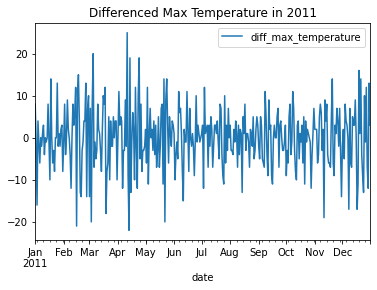

In [26]:
data['max_temperature_roll_by_1'] = np.roll(data.max_temperature, 1)
data['diff_max_temperature'] = data.max_temperature - data.max_temperature_roll_by_1
data[data.year == EXPLORATION_YEAR].plot('date','diff_max_temperature', title = f'Differenced Max Temperature in {EXPLORATION_YEAR}')

Now let's run the adfuller test again - The Differenced series is now stationary!

In [27]:
p_value_res = adfuller(data[data.year == EXPLORATION_YEAR].diff_max_temperature.values, maxlag = 5, autolag = 't-stat',regression = 'nc')[1]
print(f'Test Data: **Diff** Max Temperature series of {EXPLORATION_YEAR}, Result P_value : {round(p_value_res,2)}')

Test Data: **Diff** Max Temperature series of 2011, Result P_value : 0.0


#### 2. Difference the time entries:
We can difference the time entries from a **certain time occasion** and receive a new series that is scaled to this event.

For instance, if we model a series of alerts after a cyber attack was detected, we may want to scale the time of alerts to the detection time, since this transformation will enable to consuct a comparison between reaction times at different cyber attack events. 

#### 3. Remove trend:
Removing trend can be done by **fitting a linear regression** to model the trend, and continue in modeling the residuals, which are now clean of trend. 

As we can see, there is an increasing trend in the series of daily maximum temperatures:

<AxesSubplot:title={'center':'Increasing trend over the max temperature average series:'}, xlabel='year', ylabel='max_temperature_avg_per_year'>

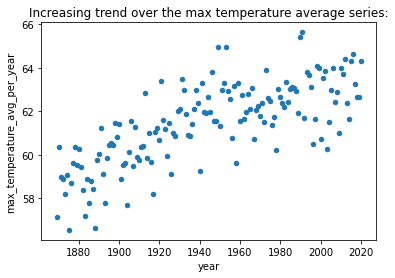

In [28]:
data.groupby('year').max_temperature.mean().reset_index().rename(columns = {'max_temperature':'max_temperature_avg_per_year'}).plot.scatter(
    'year','max_temperature_avg_per_year', title = 'Increasing trend over the max temperature average series:')

After fitting an LR model, there is **no trend observed** at the residuals series: 

<AxesSubplot:title={'center':'No Trend observed at the residuals series:'}, xlabel='year', ylabel='LR_residuals'>

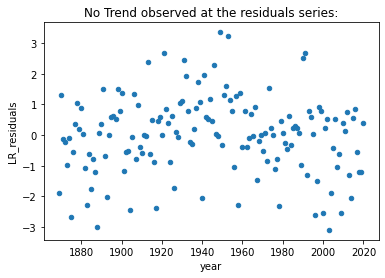

In [29]:
reg = LinearRegression().fit(data[['jul_date']], data['max_temperature'])
data['reg_pred'] = reg.predict(data[['jul_date']])
data['LR_residuals'] = data.max_temperature - data.reg_pred
data.groupby('year').LR_residuals.mean().reset_index().plot.scatter(
    'year','LR_residuals', title = 'No Trend observed at the residuals series:')

#### 4. Remove seasonality:

**4.1.** Once the seasonal lag was detected we can use it to difference the time series values by creating a new series ${Z}$ where:

${Z}_{k}$ = ${x}_{t}$ -${x}_{t - seasonality_lag}$


In [30]:
data['max_temperature_roll_by_year'] = np.roll(data.max_temperature, 365)
data['max_temperature_removed_seasonality'] = data.max_temperature - data.max_temperature_roll_by_year

<AxesSubplot:xlabel='date', ylabel='max_temperature_removed_seasonality'>

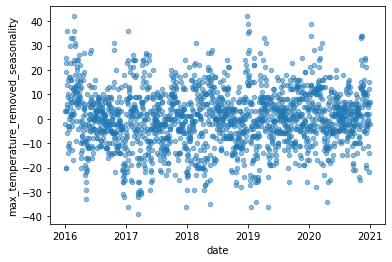

In [31]:
data[data.year>2015].plot.scatter('date', 'max_temperature_removed_seasonality',alpha = 0.5)

**4.2.** We can also use the seasonality pattern detected and calculate the average pattern values. 

For example, We can calculate the average max temperature per day of year (range : [1,365]), and create a new series: 

${Z}_{t}$ = ${x}_{t}$ -${dayofyear}_{avg}$


<AxesSubplot:xlabel='date', ylabel='max_temperature_removed_avg'>

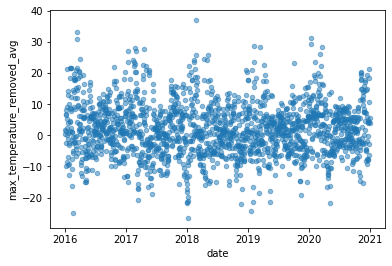

In [32]:
avg_by_dayofyear = data.groupby('dayofyear').max_temperature.mean().reset_index().rename(
    columns = {'max_temperature':'avg_max_temperature'})
data = data.merge(avg_by_dayofyear, on=['dayofyear'],how = 'left').set_index(data.index)
data['max_temperature_removed_avg'] = data.max_temperature - data.avg_max_temperature
data[data.year>2015].plot.scatter('date', 'max_temperature_removed_avg',alpha = 0.5)

#### 5. Conduct a logarithmic or exponential transformation: 
This can of transformations  may help in stablizing the variance of the series across time. 

# How to treat missing values in time series? 
Some models have a built in mechanism for it, but other models require full time series input. To [complete](https://www.kaggle.com/juejuewang/handle-missing-values-in-time-series-for-beginners) time series missing values one can:
* Interpolate the missing data by fitting a curve (for example - by using linear regression) to each full/ sub time series and complete the missing time entries by calculating the curve value. 
* Complete the missing values by an ML model 

Please remeber: Filling the missing values by using summary statistics may not work well in TS data. 

### Completing missing values example:
The missing data: 

<AxesSubplot:xlabel='date'>

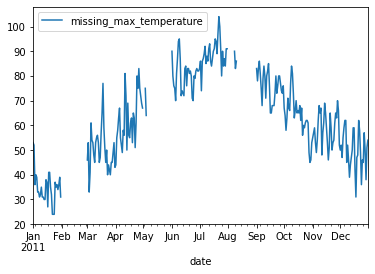

In [33]:
data[data.year == EXPLORATION_YEAR].plot('date','missing_max_temperature')

####  Completing missing values using linear interpulation:

<AxesSubplot:xlabel='date'>

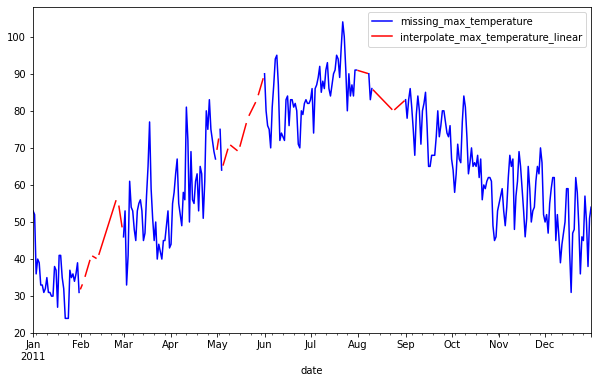

In [34]:
data['interpolate_max_temperature_linear'] = pd.DataFrame.interpolate(data.missing_max_temperature, method = 'linear')
data.loc[data.missing_max_temperature.notna(), 'interpolate_max_temperature_linear'] = np.nan
data[data.year == EXPLORATION_YEAR].plot(
    x= 'date',y = ['missing_max_temperature','interpolate_max_temperature_linear'], color = ['blue','red'], figsize = (10,6))

#### Completing missing values using the next valid observation:

<AxesSubplot:xlabel='date'>

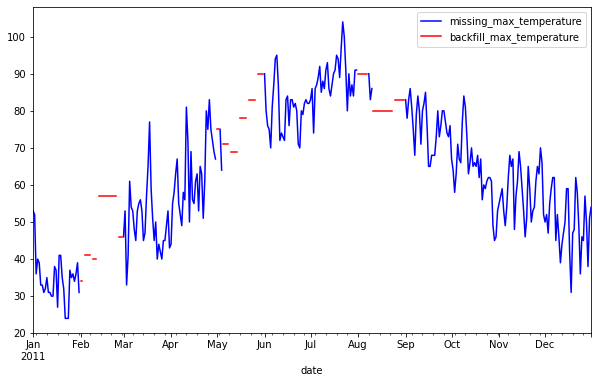

In [35]:
data['backfill_max_temperature'] = data.missing_max_temperature.fillna(value=None, method='backfill', axis=None, limit=None, downcast=None)
data.loc[data.missing_max_temperature.notna(), 'backfill_max_temperature'] = np.nan
data[data.year == EXPLORATION_YEAR].plot(x = 'date',y = ['missing_max_temperature','backfill_max_temperature'],color = ['blue','red'], figsize = (10,6))

# How to transform multi-frequency data to uni frequency data? 
When working with multivariate time series it may include series with higher frequency than others. 
For example, a low frequency series can describe a price of a sweater per day, and a high frequency series can describe the hourly temperature.

Some models assume that all time series data follows the same frequency. To provide that, we can choose to:

**Work in low frequency**: 
summarize over the highest frequency series to achieve a new low frequency series. For example, calculate the average temperature per day. 

The main drawback of this method is that we lose information by this resolution reduction. 

**Work in high frequency**: 
Expand the low frequency series to high frequency. For example, expand the daily price series mentioned before to hourly series, by duplicating the daily value 24 times. 

The main drawback of this method is that the enhanced resolution may be a misleading description of the high frequency actual observations.  In the previous example, the price may have varied during the day and didn’t have a constant value across time. 

# Great! Our data is now  ready for modeling and evaluation.
### To be discussed in the following posts, stay tuned!

